In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
%matplotlib inline  

오토인코더는 인풋을 아웃풋으로 복사하도록 훈련하는 뉴럴넷이다. 내부적으로 히든 레이어는 인풋을 나타내기 위한 Code를 설명한다. 이 네트워크는 아래와 같이 2가지 파트로 이루어져 있다.

* $h=f(x)$ : encoder (x는 인풋, h는 히든 레이어의 표현) <br>
* $r=g(h)$ : decoder (r은 reconstructed)

만약 오토인코더를 단지 $x=g(f(x))$로 둔다면 그다지 쓸모가 없을 것이다. 대신 오토인코더는 인풋을 덜 완벽하게 카피하도록 학습한다. 즉, 인풋을 근사하거나 닮게만 만드는 것이다. 왜냐하면 이를 통해, 오토인코더가 데이터 카피 그 자체가 아닌 데이터의 중요한 특성을 배우도록 하기 위해서 이다. <br>
최근의 오터인코더들은 encoder와 decoder의 개념을 판별적 함수에서 확률적 매핑을 하도록 일반화한다. $p_{encoder}(h|x)$ and $p_{decoder}(x|h)$

### Undercomplete Autoencoders 

인풋을 아웃풋으로 카피한다는 것이 쓸모없다고 들릴 수 있다. 하지만 우리는 디코더의 아웃풋(r)에 관심 있는 것이 아니다. 대신에 우리는 오토인코더가 카피하는 동안, <strong>h(히든 레이어)에 인풋의 유용한 속성(특징)들을 잘 뽑아내도록 학습하길 원한다.</strong>
한가지 방법은 $h$를 $x$의 차원보다 작아지도록 제약하는 것이다. code dimension(h)의 차원이 인풋의 차원보다 작은 오토인코더를 <strong>undercomplete</strong>라 부른다. 이러한 undercomplete representation을 학습하는 것은 오토인코더가 트레이닝 데이터의 가장 중요한 특징들을 잡아내도록 해준다. 
그 학습 과정은 간단하게 아래 loss function을 최소화하도록 할 수 있다.($L$은 $g(f(x))$와 $x$가 다르다면 벌점을 주도록 하는 loss function이다. ex. mean squared error)

$$L(x, g(f(x)))$$

decoder가 선형이고, $L$이 mean squared error라면 undercomplete autoencoder는 PCA처럼 span을 학습한다. (learns to span the same subspace as PCA)?? <br>
이 경우에, 오토인코더는 side-effect로서 트레이닝 데이터의 principal subspace를 학습하도록 카피 테스크를 수행한다.

nonliear encoder $f$와 nonlinear decoder $g$를 사용한 오토인코더는 PCA보다 더욱 강력하게 비선형적으로 일반화하여 학습할 수 있다. 하지만 만약 너무 큰 차원을 수용하려하면 이러한 기능은 잘 동작하지 않는다. 

In [2]:
# Hyper Parameters 
input_size = 784
hidden_size = 256 # undercomplete !
num_epochs = 5
batch_size = 100
learning_rate = 0.01

In [3]:
# MNIST Dataset (Images and Labels)
train_dataset = dsets.MNIST(root='../../dataset/mnist', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../../dataset/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

# Dataset Loader (Input Pipline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, input_size,hidden_size):
        super(Autoencoder, self).__init__()
        self.f = nn.Linear(input_size, hidden_size)
        self.g = nn.Linear(hidden_size, input_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = self.sigmoid(self.f(x)) # nonlinearity 
        r = self.sigmoid(self.g(h)) # nonlinearity
        return r

In [5]:
model = Autoencoder(input_size,hidden_size)

# Loss and Optimizer
# Softmax is internally computed.
# Set parameters to be updated.
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [6]:
# Training the Model
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        recon = model(images)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Loss: %.4f' 
                   % (epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch: [1/5], Step: [100/600], Loss: 0.0248
Epoch: [1/5], Step: [200/600], Loss: 0.0126
Epoch: [1/5], Step: [300/600], Loss: 0.0115
Epoch: [1/5], Step: [400/600], Loss: 0.0094
Epoch: [1/5], Step: [500/600], Loss: 0.0081
Epoch: [1/5], Step: [600/600], Loss: 0.0068
Epoch: [2/5], Step: [100/600], Loss: 0.0060
Epoch: [2/5], Step: [200/600], Loss: 0.0056
Epoch: [2/5], Step: [300/600], Loss: 0.0051
Epoch: [2/5], Step: [400/600], Loss: 0.0045
Epoch: [2/5], Step: [500/600], Loss: 0.0043
Epoch: [2/5], Step: [600/600], Loss: 0.0042
Epoch: [3/5], Step: [100/600], Loss: 0.0039
Epoch: [3/5], Step: [200/600], Loss: 0.0031
Epoch: [3/5], Step: [300/600], Loss: 0.0032
Epoch: [3/5], Step: [400/600], Loss: 0.0028
Epoch: [3/5], Step: [500/600], Loss: 0.0027
Epoch: [3/5], Step: [600/600], Loss: 0.0025
Epoch: [4/5], Step: [100/600], Loss: 0.0026
Epoch: [4/5], Step: [200/600], Loss: 0.0026
Epoch: [4/5], Step: [300/600], Loss: 0.0026
Epoch: [4/5], Step: [400/600], Loss: 0.0025
Epoch: [4/5], Step: [500/600], L

### test 

In [9]:
index

7692

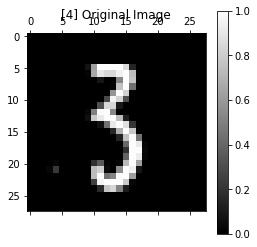

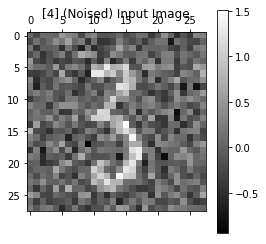

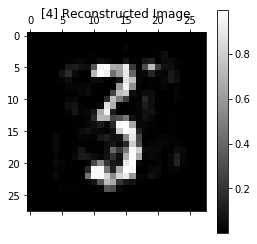

In [8]:
index = random.choice(range(10000))
test = test_dataset[index][0]

plt.matshow(np.reshape(test.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Original Image\n")
plt.colorbar()
plt.show()

noised = Variable(test) + 0.3*Variable(torch.randn(test.size()))

plt.matshow(np.reshape(noised.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] (Noised) Input Image\n")
plt.colorbar()
plt.show()

recon = model(noised.view(-1,28*28))

plt.matshow(np.reshape(recon.data.numpy(), (28, 28)), cmap=plt.get_cmap('gray'))
plt.title("[" + str(epoch) + "] Reconstructed Image\n")
plt.colorbar()
plt.show()